In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re
import pandas as pd
from nltk.corpus import stopwords
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.models import Model, load_model
from keras import layers , losses, callbacks
from keras import Input
from tensorflow.keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
stop_words = set(stopwords.words('english'))
df = pd.read_csv('./data/augmented.csv')
df['title1_en'] = df['title1_en'].apply(lambda x: str(x).lower())
df['title2_en'] = df['title2_en'].apply(lambda x: str(x).lower())
df.head()

,index,id,tid1,tid2,title1_en,title2_en,label
0,0,195611,0,1,there are two new old-age insurance benefits f...,"police disprove ""bird's nest congress each per...",unrelated
1,1,191474,2,3,"""if you do not come to shenzhen, sooner or lat...",shenzhen's gdp outstrips hong kong? shenzhen s...,unrelated
2,2,25300,2,4,"""if you do not come to shenzhen, sooner or lat...",the gdp overtopped hong kong? shenzhen clarifi...,unrelated
3,3,123757,2,8,"""if you do not come to shenzhen, sooner or lat...",shenzhen's gdp overtakes hong kong? bureau of ...,unrelated
4,4,141761,2,11,"""if you do not come to shenzhen, sooner or lat...",shenzhen's gdp outpaces hong kong? defending r...,unrelated


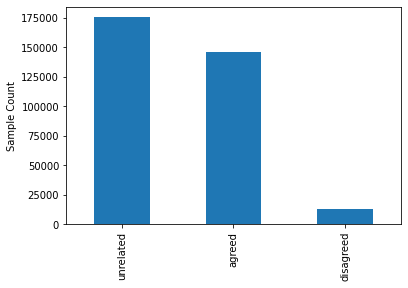

In [12]:
fig,ax = plt.subplots()
df['label'].value_counts().plot(ax = ax, kind = 'bar', ylabel = 'Sample Count')
plt.show()

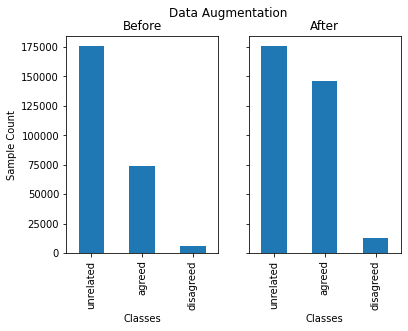

In [13]:
import matplotlib.pyplot as plt
df_train = pd.read_csv('data/train.csv')


fig,(ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.suptitle('Data Augmentation')

df_train['label'].value_counts().plot(ax = ax1, kind = 'bar', ylabel = 'Sample Count', xlabel = 'Classes', title = 'Before')
df['label'].value_counts().plot(ax = ax2, kind = 'bar', ylabel = 'Sample Count', xlabel = 'Classes', title = 'After')
plt.show()

In [14]:
#lemmatizing data
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#Preprocessing the data
def preprocess(temp):
    temp = temp.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub(r"http\S+", "", temp) #Remove links
    temp = re.sub(r"www.\S+", "", temp) #Remove links
    temp = temp.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    temp = re.sub("[^a-z0-9]"," ", temp) #Remove non-alphanumeric characters
    lemmatizer = nltk.stem.WordNetLemmatizer()
    word_list = nltk.word_tokenize(temp)
    s = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return s

In [15]:
sentence_1 = df['title1_en'].apply(preprocess)
sentence_2 = df['title2_en'].apply(preprocess)
df.loc[df['label'] == 'unrelated', 'label'] = 0
df.loc[df['label'] == 'agreed', 'label'] = 1
df.loc[df['label'] == 'disagreed', 'label'] = 2
label=df['label']
label=to_categorical(np.array(label))

In [16]:
def prep_input(tokenizer: Tokenizer, x, maxlen = 30):
    return pad_sequences(tokenizer.texts_to_sequences(x), maxlen= maxlen)

In [17]:
tokenizer = Tokenizer(num_words=20000, split=' ')
tokenizer.fit_on_texts(sentence_1)
tokenizer.fit_on_texts(sentence_2)
X_1 = prep_input(tokenizer, sentence_1, maxlen = 30)
X_2 = prep_input(tokenizer, sentence_2, maxlen = 30)

In [18]:
proportion = int(.15 * X_1.shape[0])
X1_val=X_1[:proportion]
X1_train=X_1[proportion:]

X2_val=X_2[:proportion]
X2_train=X_2[proportion:]

Y_val=label[:proportion]
Y_train=label[proportion:]

In [ ]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
embedding_matrix = np.zeros((20001, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    if i + 1 == 20000:
        break

In [ ]:
embedding_layer = layers.Embedding(20000,
                            100,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False)

In [ ]:
sentence1_input=Input(shape=[None,],name='sentence 1')
# embedding_sentence1=embedding_layer(sentence1_input)
embedding_sentence1=layers.Embedding(20000,128)(sentence1_input)
cnn_sentence1 = layers.Conv1D(128, 5, activation='relu')(embedding_sentence1)
lstm_sentence1 = layers.Bidirectional(layers.LSTM(64))(cnn_sentence1)
dense1=layers.Dense(32,activation='relu')(lstm_sentence1)

sentence2_input=Input(shape=[None,],name='sentence 2')
# embedding_sentence2=embedding_layer(sentence2_input)
embedding_sentence2=layers.Embedding(20000,128)(sentence2_input)
cnn_sentence2 = layers.Conv1D(128, 5, activation='relu')(embedding_sentence2)
lstm_sentence2 = layers.Bidirectional(layers.LSTM(64))(cnn_sentence2)
dense2=layers.Dense(32,activation='relu')(lstm_sentence2)


concatenated= layers.concatenate([dense1,dense2],axis=-1)
lstm_concatenated = layers.Dense(64,activation='relu')(concatenated)

dropout=layers.Dropout(.2)(lstm_concatenated)
output_stance=layers.Dense(3,activation='softmax')(dropout)

model=Model([sentence1_input,sentence2_input],output_stance)
model.summary()

earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = callbacks.ModelCheckpoint('model-cnn-30.h5', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss=losses.categorical_crossentropy,optimizer='rmsprop',metrics=['accuracy']) 
history=model.fit([X1_train,X2_train],Y_train,epochs=10,batch_size=128, callbacks=[earlyStopping, mcp_save], validation_data=([X1_val,X2_val],Y_val))

val_orig=history.history['val_accuracy']
accuracy=history.history['accuracy']
plt.plot(val_orig,label='Validation Accuracy')
plt.plot(accuracy,label='Training Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
#Designing architecture
from keras.backend import clear_session
clear_session()

sentence1_input=Input(shape=[None,],name='sentence 1')
embedding_sentence1=layers.Embedding(20000,128)(sentence1_input)
lstm_sentence1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedding_sentence1)
lstm_sentence1 = layers.Bidirectional(layers.LSTM(64))(lstm_sentence1)
dense1=layers.Dense(32,activation='relu')(lstm_sentence1)

sentence2_input=Input(shape=[None,],name='sentence 2')
embedding_sentence2=layers.Embedding(20000,128)(sentence2_input)
lstm_sentence2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embedding_sentence2)
lstm_sentence2 = layers.Bidirectional(layers.LSTM(64))(lstm_sentence2)
dense2=layers.Dense(32,activation='relu')(lstm_sentence2)


concatenated= layers.concatenate([dense1,dense2],axis=-1)

dropout=layers.Dropout(.2)(concatenated)
output_stance=layers.Dense(3,activation='softmax')(dropout)

model=Model([sentence1_input,sentence2_input],output_stance)
model.summary()

earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = callbacks.ModelCheckpoint('model-no-cnn.h5', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss=losses.categorical_crossentropy,optimizer='rmsprop',metrics=['accuracy']) 
history=model.fit([X1_train,X2_train],Y_train,epochs=5,batch_size=128, callbacks=[earlyStopping, mcp_save], validation_data=([X1_val,X2_val],Y_val))

val_orig=history.history['val_accuracy']
accuracy=history.history['accuracy']
plt.plot(val_orig,label='Validation Accuracy')
plt.plot(accuracy,label='Training Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [19]:
df_test = pd.read_csv('./data/test.csv')
sentence_1_test = df_test['title1_en'].apply(preprocess)
sentence_2_test = df_test['title2_en'].apply(preprocess)

In [20]:
X_1_test = prep_input(tokenizer, sentence_1_test, maxlen = 30)
X_2_test = prep_input(tokenizer, sentence_1_test, maxlen = 30)

In [21]:
# For the CSV submission

# Load best model
model_test = load_model('model-cnn.h5')


# Label prediction
arr = model_test.predict([X_1_test,X_2_test], verbose = 1).argmax(axis=-1)

2004/2004 [==============================] - 16s 7ms/step


In [22]:
df_test['label'] = arr
df_test.loc[df_test['label'] == 0, 'label'] = 'unrelated'
df_test.loc[df_test['label'] == 1, 'label'] = 'agree'
df_test.loc[df_test['label'] == 2, 'label'] = 'disagree'

sumbission = df_test[['id', 'label']]

sumbission.to_csv('.\\data\\submitted.csv')

In [25]:
lab = {0 : 'unrelated', 1: 'agree', 2: 'disagree'}
for i , row in df_test.iterrows():
    if arr[i] == 2:
        print (f"{row['title1_en']}\n{row['title2_en']}\n{lab[arr[i]]}\n")

There was gunfire and hostage-taking on Shuangqiao Road.
Police slander: the internet "twin-bridge road gun battle and hostage-taking" is not true
disagree

No Reflective Vvests Can Be Passed, January 18, 2018. Five new regulations should be taken note
Attention all car owners! All vehicles must be equipped with Reflective vest as of January 1.
disagree

Since May 1, public transportation has become a safe haven for children in China.
"The bank has lost a child's protection point?" Rumors are circulating. Friends.
disagree

liu mingwei has lost his examination certificate
Liu Mingwei's test card has been lost? It's a rumor. Don't be fooled again!
disagree

liu mingwei has lost his examination certificate
"Police disinformation" Miss Liu Mingwei's certificate of admission has been lost again?
disagree

Guangdong Province on a trial basis to cancel the Hong Kong-Macao Exit Permit and use the ID card to exit the country.
Cancellation of Hong Kong and Macao Exit Permit by the State Council